In [15]:
from brfinance import CVMAsyncBackend
import pandas as pd, numpy as np
from datetime import date
import statistics
import matplotlib.pyplot as plt

In [16]:
cvm_httpclient = CVMAsyncBackend()

# Dict de códigos CVM para todas as empresas
cvm_codes = cvm_httpclient.get_cvm_codes()

# Dict de todas as categorias de busca disponíveis (Fato relevante, DFP, ITR, etc.)
categories = cvm_httpclient.get_consulta_externa_cvm_categories()

# Realizando busca por Empresa
ano = 2020 #int(input("Qual o ano inicial para a pesquisa? "))

start_date = date(ano, 12, 31)
end_dt = date.today()
cvm_codes_list = ['21067'] # Moura_Dubeux 3694
category = ["EST_4"] # Códigos de categoria para DFP, ITR e fatos relevantes #, "EST_3", "IPE_4_-1_-1"
last_ref_date = False # Se "True" retorna apenas o último report no intervalo de datas

# Busca
search_result = cvm_httpclient.get_consulta_externa_cvm_results(
    cod_cvm=cvm_codes_list,
    start_date=start_date,
    end_date=end_dt,
    last_ref_date=last_ref_date,
    category=category
    )

# Filtrar dataframe de busca para DFP e Status Ativo
search_result = search_result[
    (search_result['categoria']=="DFP - Demonstrações Financeiras Padronizadas")]
search_result = search_result[search_result['status']=="Ativo"]
search_result = search_result[search_result['ref_date']>=str(start_date)]
search_result = search_result[pd.to_numeric(search_result['numero_seq_documento'], errors='coerce').notnull()]

reports_list = [
    'Balanço Patrimonial Ativo',
    'Balanço Patrimonial Passivo',
    'Demonstração do Resultado',
    'Demonstração do Fluxo de Caixa'] # Se None retorna todos os demonstrativos disponíveis.

#Lista vazia para armazenas os dataframes
dfs = []

# Obter demonstrativos
for index, row in search_result.iterrows():
    empresa = f"{row['cod_cvm']} - {cvm_codes[row['cod_cvm']]}"

    reports = cvm_httpclient.get_report(row["numero_seq_documento"], row["codigo_tipo_instituicao"], reports_list=reports_list)
    for report in reports:
        reports[report]["cod_cvm"] = row["cod_cvm"]

        #Adicionar os dataframes em uma lista
        dfs.append(reports[report])    

#Concatenar os dataframes em um único dataframe
df_concat = pd.concat(dfs,ignore_index=True)

# Salvar o dataframe no arquivo excel, repetindo as linhas das DFPs conforme os anos do filtro
df_concat.to_excel('Dados_CVM.xlsx', index=False)

# Criar pivot table
pivot_table = pd.pivot_table(df_concat, index=["Conta", "Descrição"], values=["Valor"], aggfunc=lambda x: "\n".join(str(i) for i in x))

# Salvar pivot table em um arquivo Excel
pivot_table.to_excel("Dados_CVM_Filtrados.xlsx")

# Carregar o arquivo pivot_table.xlsx em um DataFrame pandas
df_pivot = pd.read_excel('Dados_CVM_Filtrados.xlsx')

# Obter o número máximo de valores em uma única célula "Valor" em todo o DataFrame
max_values = int(df_pivot['Valor'].str.count('\n').max()) + 1
value_cols = [f'{ano+i}' for i in reversed(range(max_values))]
df_pivot[value_cols] = df_pivot['Valor'].str.split('\n', expand=True)

# Separar os valores da coluna "Valor" em colunas separadas
df_pivot[value_cols] = df_pivot['Valor'].str.split('\n', expand=True)

# Remover a coluna "Valor" original
df_pivot = df_pivot.drop(columns=['Valor'])

# Ordenar colunas em ordem crescente, mantendo as duas primeiras colunas
all_cols = list(df_pivot.columns)
ordered_cols = all_cols[:2] + sorted(all_cols[2:])

# Reagrupamento das colunas no DataFrame
df_pivot = df_pivot.reindex(columns=ordered_cols)

#Filtrar dados
df_pivot.query('Conta == "3.01" | Conta == "3.02" | Conta == "6.01.01.03" \
    | Conta == "3.06" | Conta == "3.08" | Conta == "3.04" | Conta == "3.11" \
    | Conta == "6.01.02" | Conta == "6.02.04"', inplace = True)

#Formatar estilo
#df_pivot.style.format(decimal=",")

# Salvar o DataFrame atualizado em um arquivo Excel
df_pivot.to_excel('Case_Base.xlsx', index=False)


c:\Users\Lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\brfinance\responses.py:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  response_df = response_df.append(search_results_df)
c:\Users\Lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\brfinance\responses.py:127: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df.set_axis([*df.columns[:-1], 'Valor'], axis=1, inplace=True)
c:\Users\Lucas\AppData\Local\Programs\Python\Python311\Lib\site-packages\brfinance\responses.py:127: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df.set_axis([*df.columns[:-1], 'Valor'], axis=1, inplace=True)
c:\Users\Lucas\AppData\Local\Programs\Python\Python311\Lib\site-pac

In [17]:
############################################# Lucro Bruto #########################################################

# Ler o arquivo "Case_Base.xlsx" em um DataFrame
df = pd.read_excel("Case_Base.xlsx")

#Inicializando 
Lucro_Bruto = []
for i in range((len(df.columns)-2)):
    Lucro_Bruto.append(pd.to_numeric(df.loc[df["Conta"].isin(["3.01", "3.02"]), f"{ano+i}"]).sum())

# Criar novo DataFrame com a nova linha
new_row = pd.DataFrame([["3.01+3.02", "Lucro Bruto"] + Lucro_Bruto], columns=df.columns)

# Concatenar o novo DataFrame com o DataFrame original
df = pd.concat([df, new_row], ignore_index=True)

In [18]:
############################################# EBIT #########################################################

# selecionando a linha Depreciação e Armotização e multiplicando os valores por -1
#for i in range((len(df.columns)-2)):
    #df.loc[6,f"{ano+i}"] = df.loc[6,f"{ano+i}"] * -1

#Inicializando 
EBIT = []
for i in range((len(df.columns)-2)):
    df.loc[6,f"{ano+i}"] = df.loc[6,f"{ano+i}"] * -1 #selecionando a linha Depreciação e Armotização e multiplicando os valores por -1
    EBIT.append(pd.to_numeric(df.loc[df["Conta"].isin(["3.01+3.02", "3.04", "6.01.01.03"]), f"{ano+i}"]).sum())

# Criar novo DataFrame com a nova linha
new_row = pd.DataFrame([["fx1", "EBIT"] + EBIT], columns=df.columns)

# Concatenar o novo DataFrame com o DataFrame original
df = pd.concat([df, new_row], ignore_index=True)


# Salvar o DataFrame atualizado em um arquivo Excel
#df.to_excel("Case_Base.xlsx", index=False)

In [19]:
############################################# NOPAT #########################################################
#Inicializando 
NOPAT = []
for i in range((len(df.columns)-2)):
    NOPAT.append(pd.to_numeric(df.loc[10,f"{ano+i}"] * (1 - abs(df.loc[4,f"{ano+i}"]/df.loc[10,f"{ano+i}"]))))

# Criar novo DataFrame com a nova linha
new_row = pd.DataFrame([["fx2", "NOPAT"] + NOPAT], columns=df.columns)

# Concatenar o novo DataFrame com o DataFrame original
df = pd.concat([df, new_row], ignore_index=True)

# Salvar o DataFrame atualizado em um arquivo Excel
#df.to_excel("Case_Base.xlsx", index=False)

In [20]:
############################################# FreeCashFlowtoFirm #########################################################
#Inicializando 
FreeCash = []
for i in range((len(df.columns)-2)):
    FreeCash.append(pd.to_numeric(df.loc[11,f"{ano+i}"] + df.loc[6,f"{ano+i}"] - df.loc[7,f"{ano+i}"] - df.loc[8,f"{ano+i}"]))

# Criar novo DataFrame com a nova linha
new_row = pd.DataFrame([["fx3", "FreeCashFlow"] + FreeCash], columns=df.columns)

# Concatenar o novo DataFrame com o DataFrame original
df = pd.concat([df, new_row], ignore_index=True)

# Salvar o DataFrame atualizado em um arquivo Excel
df.to_excel("Case_Base.xlsx", index=False)

In [21]:
############################################# Inputs #########################################################

#Taxa de Crescimento Anual
#yoy_Growth_Rate = int(input("Qual a taxa de crescimento anual(%)? "))
yoy_gwth_rate = 0.05
yoy_gwth_rate_ = []
for i in range((len(df.columns)-2)):
    yoy_gwth_rate_.append(yoy_gwth_rate)

# Criar novo DataFrame com a nova linha
new_row = pd.DataFrame([["7.01", "Taxa de Crescimento Anual"] + yoy_gwth_rate_], columns=df.columns)

# Concatenar o novo DataFrame com o DataFrame original
df = pd.concat([df, new_row], ignore_index=True)

#Weighted Average Cost of Capital
#WACC = int(input("Qual custo médio ponderado de capital(%)? "))
wacc = 0.09
wacc_ = []
for i in range((len(df.columns)-2)):
    wacc_.append(wacc)

# Criar novo DataFrame com a nova linha
new_row = pd.DataFrame([["7.02", "Custo Médio Ponderado de Capital"] + wacc_], columns=df.columns)

# Concatenar o novo DataFrame com o DataFrame original
df = pd.concat([df, new_row], ignore_index=True)

#Perpetual Growth Rate
#perpetual_Growth_Rate = int(input("Qual a taxa de crescimento perpétua(%)? "))
perp_gwth_rate = 0.015
perp_gwth_rate_ = []
for i in range((len(df.columns)-2)):
    perp_gwth_rate_.append(perp_gwth_rate)

# Criar novo DataFrame com a nova linha
new_row = pd.DataFrame([["7.03", "Taxa de Crescimento Perpétua"] + perp_gwth_rate_], columns=df.columns)

# Concatenar o novo DataFrame com o DataFrame original
df = pd.concat([df, new_row], ignore_index=True)

# Salvar o DataFrame atualizado em um arquivo Excel
df.to_excel("Case_Base.xlsx", index=False)

In [22]:
def calculate_rate(array):
    n = len(array) - 1
    initial_value = array[0]
    final_value = array[-1]
    rate = (final_value / initial_value) ** (1 / n) - 1
    return rate

In [23]:
class DCFMonteCarlo: 
    def __init__(self, **kwargs):
        valid_arg = ["num_years","initial_sales","sales_gwt","sales_gwt_stddev","int_exp_rate", "int_exp_rate_stddev",
                    "var_nwc_gwt","var_nwc_gwt_stddev","cogs_rate", "cogs_rate_stddev", 
                    "sga_rate", "sga_rate_stddev","dep_amort_driver","dep_amort_driver_stddev","tax_rate",
                    "capex_da_ratio","capex_da_ratio_stddev","perp_gwth_rate","wacc","num_simulations"]
        for key in valid_arg:
            setattr(self, key, kwargs.get(key))
    
    def profit_bef_tax(self, sales, cogs, sga, dep_amort, int_exp):
        profit_before_tax = sales + cogs + sga + dep_amort + int_exp
        return profit_before_tax
    
    def fcf(self, net_income, int_exp, dep_amort, var_nwc, capex):
        fcf = net_income - int_exp - dep_amort + var_nwc + capex
        return fcf
    
    def normal_dist(self, metric, metric_stddev):
        return np.random.normal(loc=metric, scale=metric_stddev, size=(self.num_years, self.num_simulations))

    def disc_fcf_coeff(self):
        return [1 / (1 + self.wacc) ** n for n in range(1, self.num_years + 1)]

    def dsctd_fcf(self, fcf):
        dsc = sum((fcf.transpose() * self.disc_fcf_coeff()).transpose())
        return dsc
    
    def terminal_value(self, fcf):
        tv = (fcf[-1] * ((1 + self.perp_gwth_rate) / (self.wacc - self.perp_gwth_rate))) * self.disc_fcf_coeff()[-1]
        return tv
    
    def sales(self, sales_gwt):
        sales_gwt = 1 + sales_gwt
        for x in range(1, self.num_years):
            sales_gwt[x] = sales_gwt[x] * sales_gwt[x - 1]
        sales  = self.initial_sales * sales_gwt
        return sales

    def estimate(self):
        stored_values = []
        sales_gwt = self.normal_dist(self.sales_gwt, self.sales_gwt_stddev)
        int_exp_rate = self.normal_dist(self.int_exp_rate, self.int_exp_rate_stddev)
        var_nwc_gwt = self.normal_dist(self.var_nwc_gwt, self.var_nwc_gwt_stddev)
        cogs_rate = self.normal_dist(self.cogs_rate, self.cogs_rate_stddev)
        sga_rate = self.normal_dist(self.sga_rate, self.sga_rate_stddev)
        dep_amort_driver = self.normal_dist(self.dep_amort_driver, self.dep_amort_driver_stddev)
        capex_da_ratio = self.normal_dist(self.capex_da_ratio, self.capex_da_ratio_stddev)
        sales = self.sales(sales_gwt)
        cogs = -sales * cogs_rate
        sga = -sales * sga_rate
        dep_amort = -sales * dep_amort_driver
        int_exp = -sales * int_exp_rate
        profit_bef_tax = self.profit_bef_tax(sales, cogs, sga, dep_amort, int_exp)
        tax = -profit_bef_tax * 0.33 #tax_rate
        net_income = profit_bef_tax + tax
        capex = dep_amort * capex_da_ratio
        var_nwc = capex * var_nwc_gwt
        fcf = self.fcf(net_income, int_exp, dep_amort, var_nwc, capex)
        disc_fcf_coeff = self.disc_fcf_coeff()
        dsctd_fcf = self.dsctd_fcf(fcf)
        terminal_value = self.terminal_value(fcf)
        final_estimation = terminal_value + dsctd_fcf
        stored_values.append(final_estimation)
        return stored_values


In [31]:
df = pd.read_excel("Case_Base.xlsx")
print(round(calculate_rate((df.iloc[0][2:]).astype(float)),3))

0.248


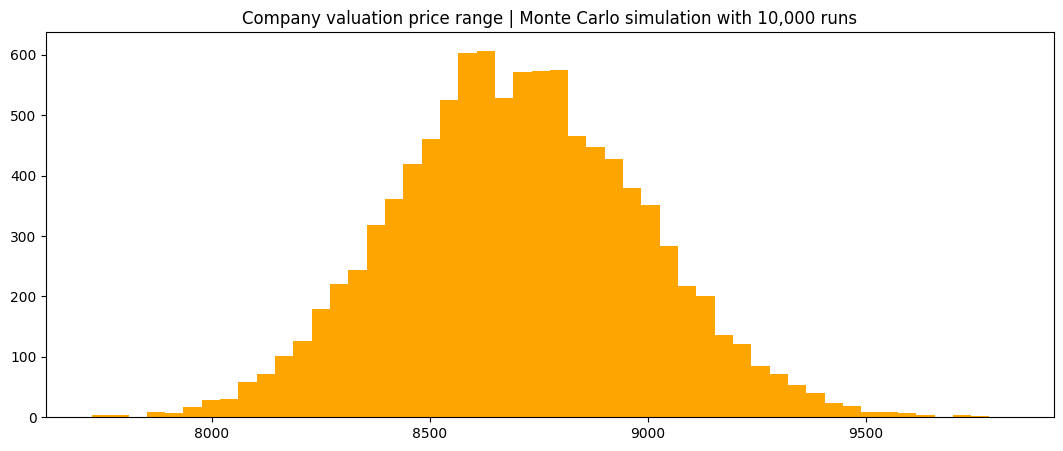

In [32]:
df = pd.read_excel("Case_Base.xlsx")

params = {
    "num_years": len(df.columns)-2,
    "initial_sales": ((sum((df.iloc[0][2:]).astype(float))/(len(df.columns) - 2))/1000),
    "sales_gwt": round(calculate_rate((df.iloc[0][2:]).astype(float)),3),
    "sales_gwt_stddev": 0.02,
    "int_exp_rate": round(calculate_rate((abs(df.iloc[3][2:])).astype(float)),3),
    "int_exp_rate_stddev": 0.005,
    "var_nwc_gwt": abs(round(calculate_rate((abs(df.iloc[7][2:])).astype(float)),3)),
    "var_nwc_gwt_stddev": 0.02,
    "cogs_rate": round(calculate_rate((abs(df.iloc[1][2:])).astype(float)),3),
    "cogs_rate_stddev": 0.015,
    "sga_rate": abs(round(calculate_rate((abs(df.iloc[2][2:])).astype(float)),3)),
    "sga_rate_stddev": 0.01,
    "dep_amort_driver": round(calculate_rate((abs(df.iloc[6][2:])).astype(float)),3),
    "dep_amort_driver_stddev": 0.001,
    "capex_da_ratio": round(calculate_rate((abs(df.iloc[8][2:])).astype(float)),3),
    "capex_da_ratio_stddev": 0.01,
    "tax_rate": 0.33,
    "perp_gwth_rate": perp_gwth_rate,
    "wacc": wacc,
    "num_simulations": 10000
}

# Cálculo do valor da empresa usando a classe DCFMonteCarlo
company_value = DCFMonteCarlo(**params)

# Cálculo da faixa de valores usando a função estimate() e plotagem do histograma
value_range = company_value.estimate()
plt.figure(figsize=(13,5))
plt.title("Company valuation price range | Monte Carlo simulation with 10,000 runs")
plt.hist(value_range,  color="orange", bins=50, )
plt.show()

In [33]:
df = pd.DataFrame({'company_prices':list(value_range[0])})
df.describe()

,company_prices
count,10000.000000
mean,8702.313694
std,285.346511
min,7724.944401
25%,8510.400846
50%,8697.547768
75%,8896.788921
max,9825.391381


In [34]:
low_price = df.mean() - df.std()
high_price = df.mean() + df.std()
cases_num = df.loc[(df.company_prices >= int(low_price)) & (df.company_prices <= int(high_price))].count() / df.count()
print("Taget price is at ${3}M, low price is ${0}M and its high price is ${1}M in {2}% of \
    the cases".format(low_price.values[0].astype(int),\
        high_price.values[0].astype(int), int(cases_num), int(df.mean().values[0])))


Taget price is at $8702M, low price is $8416M and its high price is $8987M in 0% of     the cases
